In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.preprocessing as Preprocessing
import skimage.io
import skimage.filters
import skimage.color

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

## Normalize image

In [2]:
def normalize(im):
    im = im - np.amin(im)
    im = im/np.amax(im)
    return im

## Contrast stretching

(151, 200, 3)


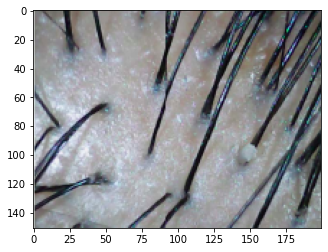

In [3]:
img = cv2.imread('./photos/scalp/image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# dont resize
# img = cv2.resize(img, (400, 300))
plt.imshow(img)
print(img.shape)

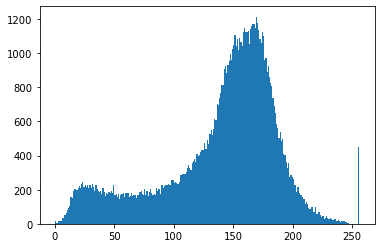

In [4]:
# # alternative way to find histogram of an image
plt.hist(img.ravel(),256,[0,256])
plt.show()

#### Final Function

In [5]:
def contrast_stretch(im, r1, s1, r2, s2):
    '''
    applies a linear transform to stretch the contrast
    im -> normalized image (0 to 1)
    r,s are transit points
    r1 mapped to s1 and r2 mapped to s2
    '''
    im = normalize(im)
    
    m = (s2-s1)/(r2-r1)
    im2 = im-r1
    im2 = im2*m
    im2 = im2 + s1
    
#     normalize
    im2 = normalize(im2)
    im2 = im2 * 255
    im2 = im2.astype('uint8')
    return im2

sun :  {(0.25, 0.1), (0.75, 1)}
dark :  {(0.08, 0.02), (0.75, 0.85)}

In [6]:
cim = contrast_stretch(img, 0.08, 0.02, 0.75, 0.85)
# cim = img.copy()

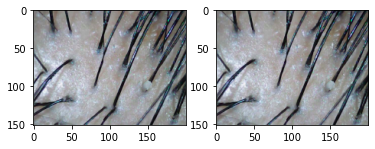

In [7]:
_, axarr = plt.subplots(1,2)

axarr[0].imshow(img)
axarr[1].imshow(cim)

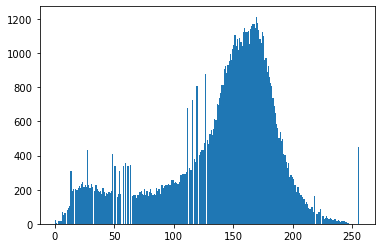

In [8]:
# # alternative way to find histogram of an image
cim_copy = cim
plt.hist(cim_copy.ravel(),256,[0,256])
plt.show()

## Bright spot removal (using mathematical morphology)

In [9]:
def bright_spot_removal(contrast_stretched_im, thresh, inpaint_radius, kernel=np.ones((3,3), np.uint8)):
    contrast_stretched_im = cv2.morphologyEx(contrast_stretched_im, cv2.MORPH_OPEN, kernel)
    opening = cv2.cvtColor(contrast_stretched_im, cv2.COLOR_RGB2GRAY)
    mask = Preprocessing.binarize(opening, threshold=thresh)
    #kernel2 = np.ones((2,2), np.uint8)
    opening = cv2.inpaint(contrast_stretched_im, mask.astype('uint8'), inpaint_radius, cv2.INPAINT_NS)
    return opening

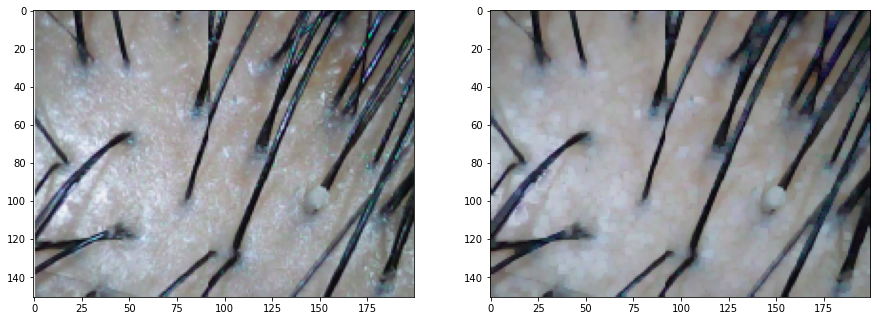

In [10]:
spot_removed = bright_spot_removal(cim, thresh = 200, inpaint_radius = 5)
_, axarr = plt.subplots(1,2,figsize=(15,15))

axarr[0].imshow(cim)
axarr[1].imshow(spot_removed, cmap='binary')

## KL transform

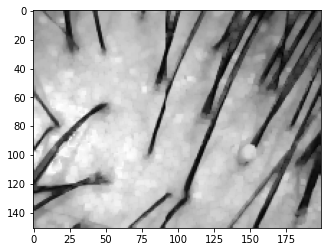

In [11]:
opening = cv2.cvtColor(spot_removed, cv2.COLOR_BGR2GRAY)
plt.imshow(opening, cmap="gray")

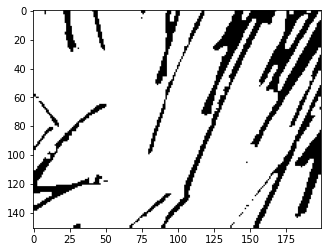

In [12]:
otsu_threshold, binary = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,)
binary = Preprocessing.binarize(opening, threshold=otsu_threshold - 30)
# binary = opening.copy()
(x, y) = binary.shape
for i in range(0,x):
    for j in range(0,y):
        if binary[i][j] == 0:
            binary[i][j] = 255
        else:
            binary[i][j] = 0
            
plt.imshow(binary, cmap="binary")

## Rescaling

In [13]:
def rescaling(binary_img):
    img_l = cv2.resize(binary_img, (1024, 768))
    img_m = cv2.resize(binary_img, (512, 384))
    img_s = cv2.resize(binary_img, (256, 192))
    
    return(img_l, img_m, img_s)

In [14]:
img_l, img_m, img_s = rescaling(binary)

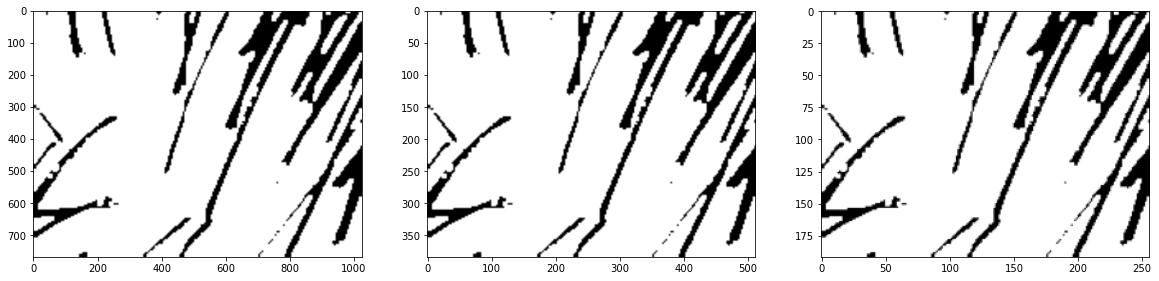

In [15]:
_, axarr = plt.subplots(1,3,figsize=(20,20))

axarr[0].imshow(img_l, cmap="binary")
axarr[1].imshow(img_m, cmap="binary")
axarr[2].imshow(img_s, cmap="binary")

## Canny Edge

In [16]:
def canny(image):
#     edge = feature.canny(image, sigma=0)
    highThresh = otsu_threshold
    lowThresh = 0.5*highThresh
    edges = cv2.Canny(image,lowThresh,highThresh)
    return edges

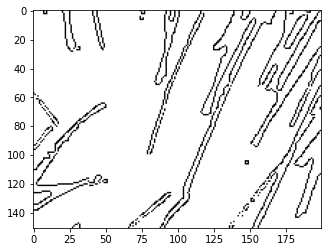

In [17]:
edge = canny(binary)
plt.imshow(edge, cmap="binary")

## Thinning

In [18]:
img = np.float32(binary)

In [19]:
def thin(img):
    kernel2 = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel2, iterations=1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    # Create an empty output image to hold values
    thin = np.zeros(img.shape,dtype='uint8')
    img1 = img
    # Loop until erosion leads to an empty set
    itr = 0
    while (itr<25):
        # Erosion
        itr+=1
        erode = cv2.erode(img1,kernel)
        # Opening on eroded image
        opening = cv2.morphologyEx(erode,cv2.MORPH_OPEN,kernel)
        # Subtract these two
        subset = erode - opening
        # Union of all previous sets
        thin = cv2.bitwise_or(np.float32(subset),np.float32(thin))
        # Set the eroded image for next iteration
        img1 = erode.copy()
    return(thin)

In [62]:
thinn = thin(img)
thinn = cv2.dilate(thinn, np.ones((2,2), np.uint8), iterations=1)
thinn = cv2.erode(thinn, np.ones((2,2), np.uint8), iterations=1)

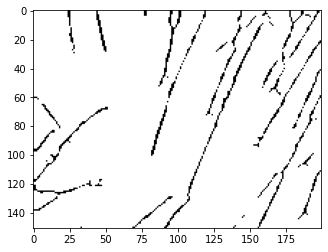

In [63]:
plt.imshow(thinn, cmap="binary")

## Hough LinesP

In [22]:
def HTP(img, thresh, color):
    lines = cv2.HoughLinesP(np.uint8(img), 1, np.pi/180, thresh)
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),1)
    return line_im

In [23]:
hpt = HTP(thinn, 20, 'r')

In [24]:
tl = thin(img_l)
hl = HTP(tl, 20, 'r')

tm = thin(img_m)
hm = HTP(tm, 20, 'g')

ts = thin(img_s)
hs = HTP(ts, 20, 'b')

h1 = cv2.resize(hl, (1024, 768))
h2 = cv2.resize(hm, (1024, 768))
h3 = cv2.resize(hs, (1024, 768))

tl = cv2.resize(tl, (1024, 768))
tm = cv2.resize(tm, (1024, 768))
ts = cv2.resize(ts, (1024, 768))

In [25]:
hf = (h1 + h2 + h3)/3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


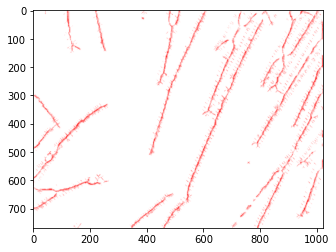

In [26]:
plt.imshow(hf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/home/rushil/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/image.py:482: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


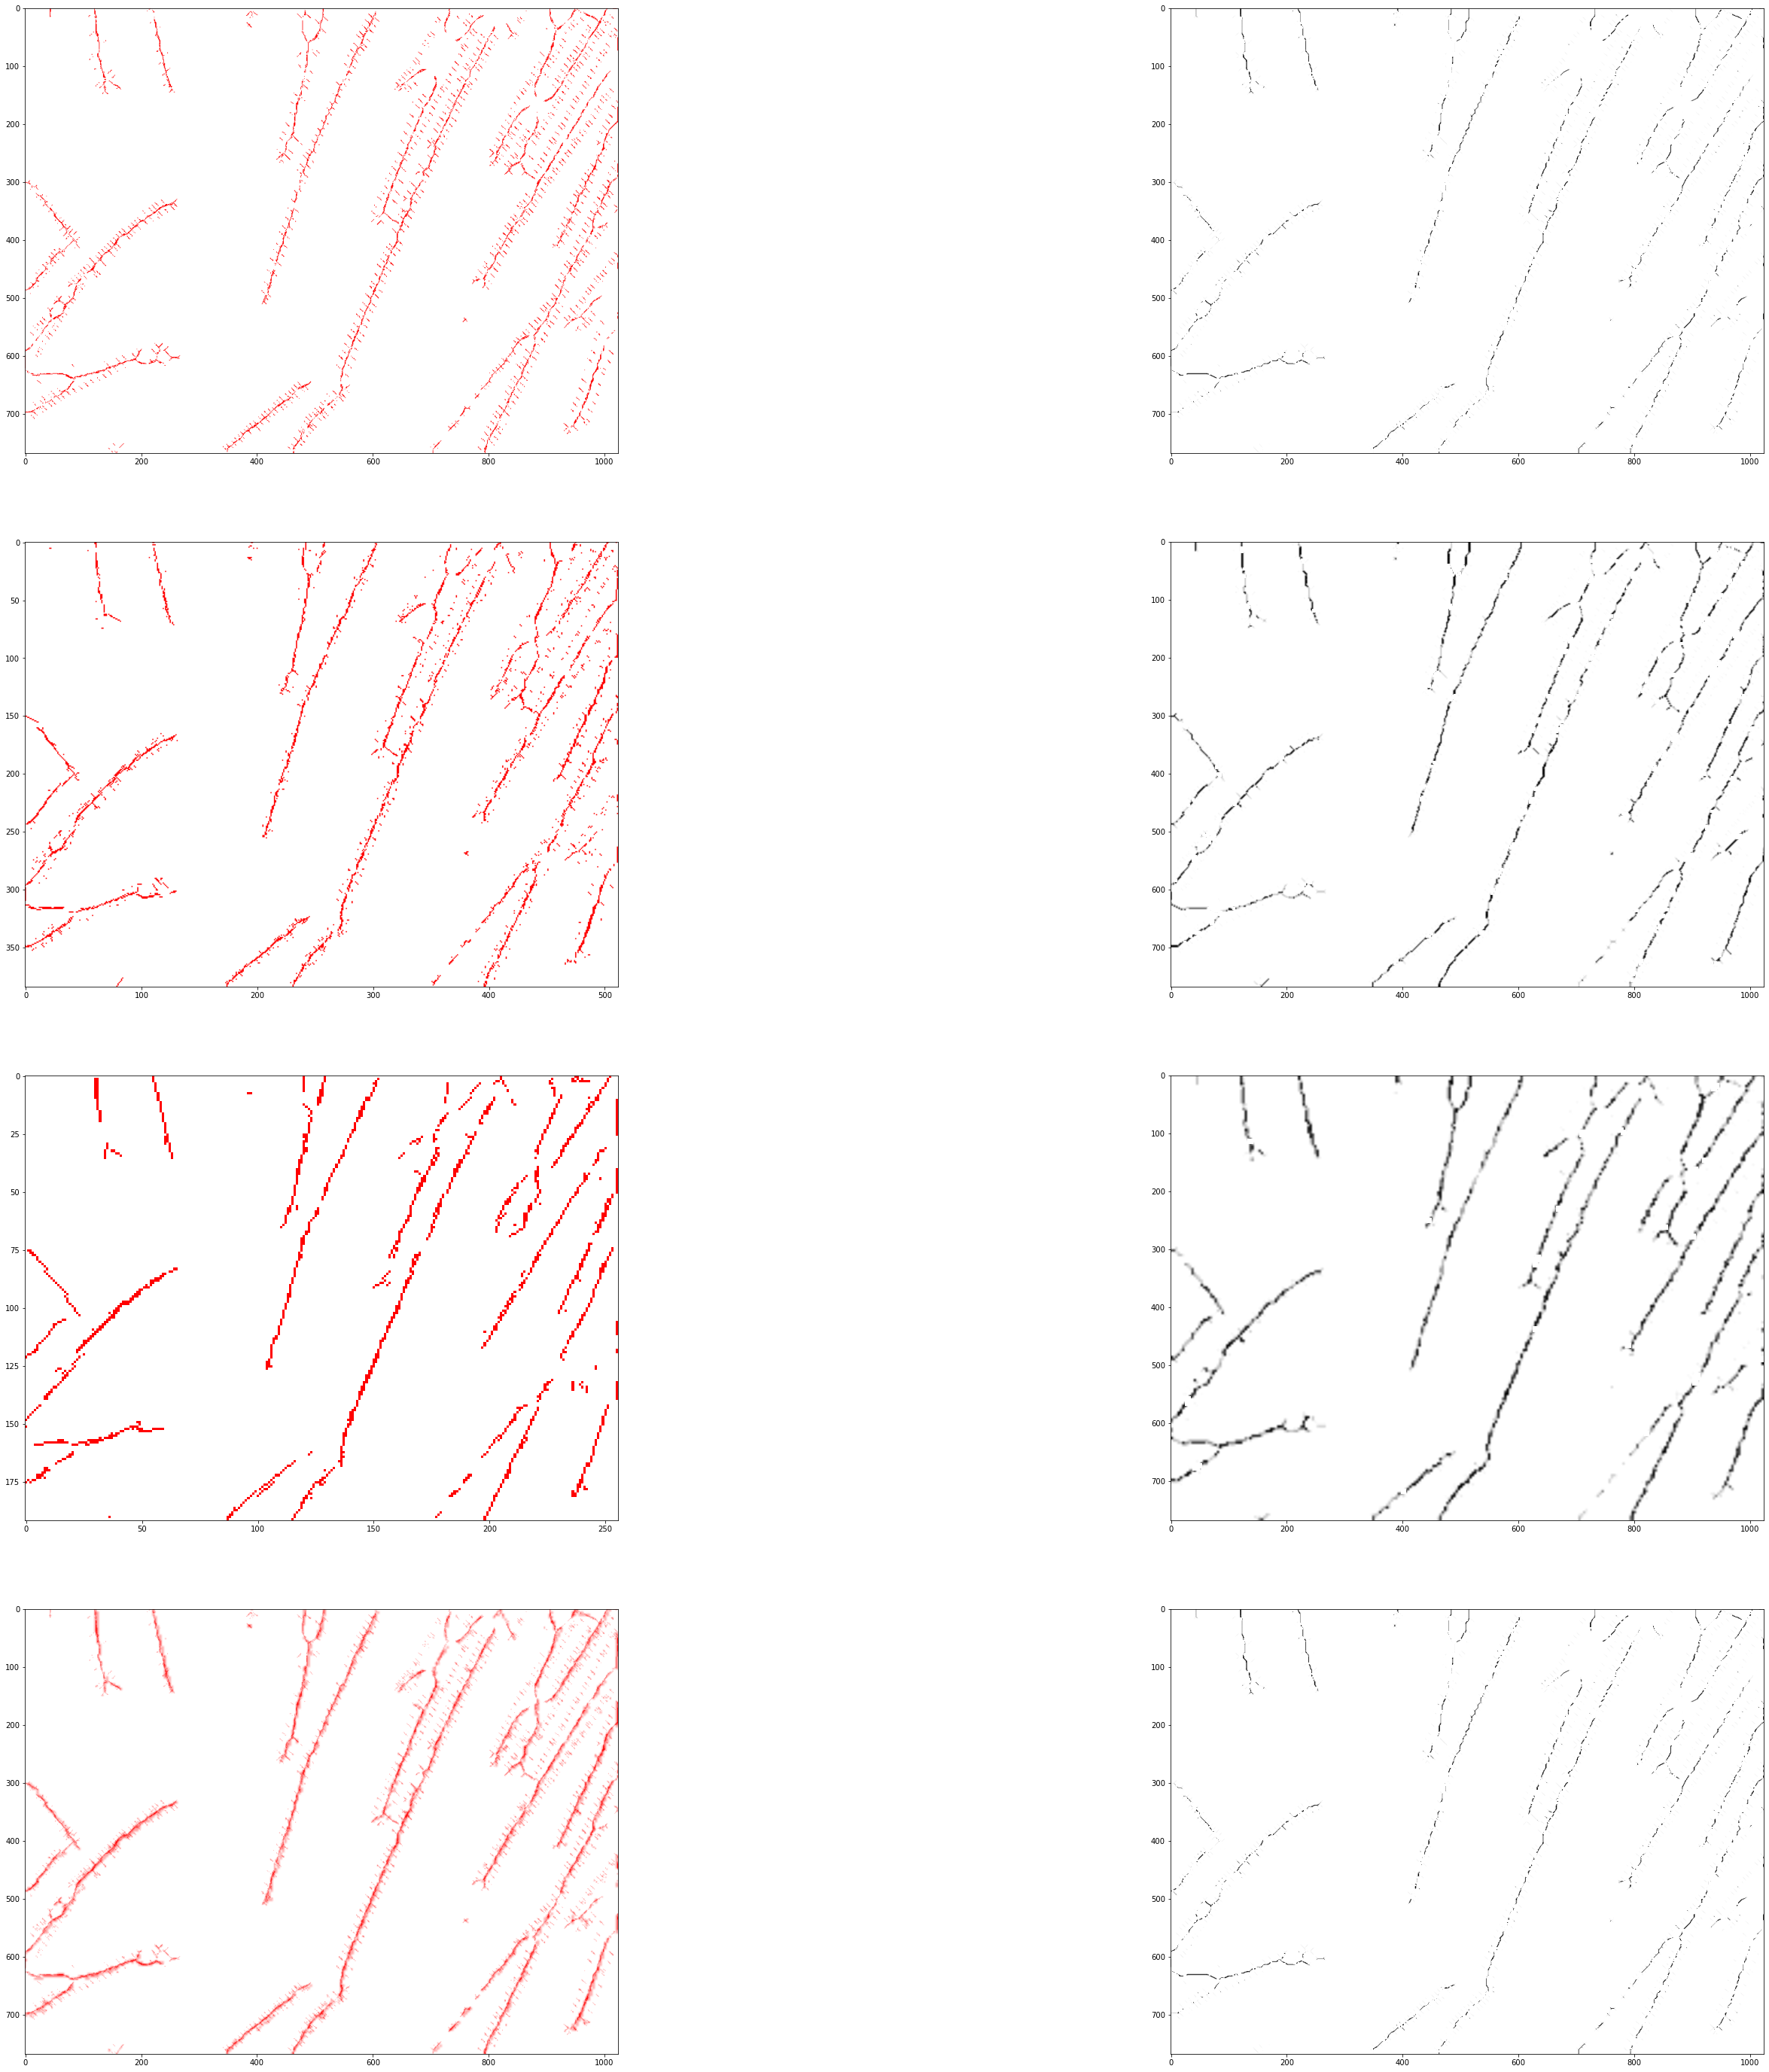

In [27]:
_, axarr = plt.subplots(4,2,figsize=(50,50))

axarr[0][0].imshow(h1)
axarr[0][1].imshow(tl, cmap="binary")
axarr[1][0].imshow(hm)
axarr[1][1].imshow(tm, cmap="binary")
axarr[2][0].imshow(hs)
axarr[2][1].imshow(ts, cmap="binary")
axarr[3][0].imshow(hf)
axarr[3][1].imshow(tl, cmap="binary")


#### Parallel Line Bundling

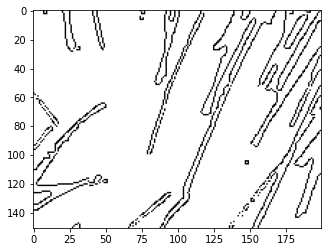

In [28]:
plt.imshow(edge, cmap="binary")

In [29]:
# HTP
def PLB(img, thresh):
    ms = []
    lines = cv2.HoughLinesP(np.uint8(img), 1, np.pi/180, thresh)
    print(len(lines))
    line_im = np.ones( (img.shape[0], img.shape[1], 3) )
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            cv2.line(line_im,(x1,y1),(x2,y2),(255,0,0),3)
            m = (y2-y1)/((x2-x1)+0.00000001)
            ms.append(m)
    return line_im, ms

In [30]:
ht, ms = PLB(edge, 50)

27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


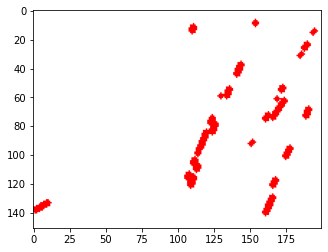

In [31]:
plt.imshow(ht)

In [32]:
ms

[-2.999999985,
 -2.9999999700000006,
 -2.3333333255555555,
 -2.49999999375,
 0.0,
 -100000000.0,
 -0.9999999900000002,
 -2.4999999875000003,
 -2.999999985,
 -1.4999999925,
 -2.1999999956,
 -2.9999999700000006,
 -1.99999999,
 -3.9999999600000007,
 -1.9999999933333334,
 -1.4999999981249998,
 -0.9999999900000002,
 -100000000.0,
 -200000000.0,
 -0.9999999900000002,
 -2.4999999875000003,
 -1.9999999800000003,
 0.0,
 -2.9999999700000006,
 -0.5555555549382716,
 -1.4999999925,
 -2.9999999700000006]

## rescaling

In [33]:
def rescale_pre(img):
    img = np.uint8(img)
    
    img1 = cv2.resize(img, (1024, 768))
    img2 = cv2.resize(img, (512, 384))
    img3 = cv2.resize(img, (256, 192))
    
    ht1 = HT(img1, 0)
    ht2 = HT(img2, 0)
    ht3 = HT(img3, 0)
    
    ht2 = cv2.resize(ht2, (1024, 768))
    ht3 = cv2.resize(ht3, (1024, 768))
    
    ht = ht1 + ht2 + ht3
    return ht

In [34]:
ht = rescale_pre(thinn)

NameError: name 'HT' is not defined

In [ ]:
img3 = cv2.resize(np.uint8(thinn), (256, 192))

In [ ]:
plt.imshow(img2, cmap="binary")

In [ ]:
ht2 = HT(img3, 0)

In [ ]:
plt.imshow(ht, cmap="binary")